## **Multi-Armed Bandit Problem**

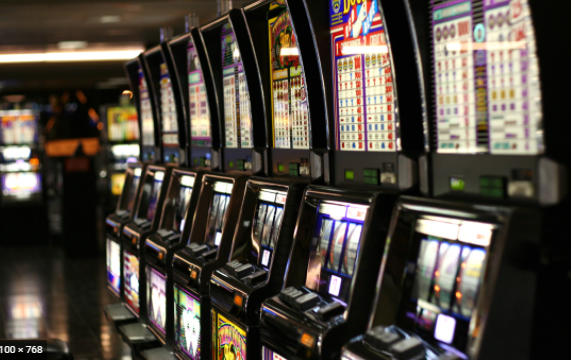

In probability theory and machine learning, the multi-armed bandit problem is a problem in which we need to figure out how to allocate a fixed quantity of a limited resource (such as time, money, turns, etc.) among of set of competing options in such a way that we can maximize our expected rewards.

Actual rewards from any of the available options are not fully known, but may become better understood by allocating resources to each option

This is a classic reinforcement learning problem that exemplifies the exploration-exploitation trade-off dilemma.

The multi-armed bandit problem is a classic reinforcement learning example where we are given a slot machine with n arms (bandits) with each arm having its own rigged probability distribution of success. Pulling any one of the arms gives you a stochastic reward of either R=+1 for success, or R=0 for failure. Our objective is to pull the arms one-by-one in sequence such that we maximize our total reward collected in the long run.


## **Abstract**

Bernoulli trial or a Binomial trial is a random experiment with exactly two possible outcomes - "Success" OR "Failure". 

For example - Click on a link on not click, buy or not buy.

Here we simulate some real-world data like Ads and model it with Thompson Sampling with Beta Distribution and other Algorithms like Epsilon-Greedy, Upper Confidence Bound and Random Sampling.

We optimize the algorithms, study the importance of hyperparameters for each of the algorithms and how it affects performance.


**Importing Libraries**

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

**Initializing the Bandits**

In [7]:
stationary=True
class ads_bandits():
  def __init__(self, ads_campaign):
    """
    Multi-armed bandit with rewards 1 or 0.
    
    At initialization, multiple arms are created. The probability of each arm
    returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
    chosen from Uniform(0,1) at initialization
    """
    self.ads_campaign = ads_campaign
    self.generate_thetas()
    self.timestep = 0
    global stationary
    self.stationary=stationary
    
  def generate_thetas(self):
    self.thetas = np.random.uniform(0,1,self.ads_campaign)
  
  def get_reward_regret(self, arm):
    """ Returns random reward for an ad. Assumes actions are 0-indexed
    Args:
      ads_campaign is an int
    """
    self.timestep += 1
    if (self.stationary==False) and (self.timestep%100 == 0) :
      self.generate_thetas()
    # Simulate bernouilli sampling
    sim = np.random.uniform(0,1,self.ads_campaign)
    rewards = (sim<self.thetas).astype(int)
    reward = rewards[arm]
    regret = self.thetas.max() - self.thetas[arm]
    
    return reward, regret
   

## **Thompson Sampling**

Thompson sampling is an ingenious algorithm that implicitly balances exploration and exploitation based on quality and uncertainty.

Thompson sampling, incorporates uncertainty by modelling the bandit's Bernouilli parameter with a prior beta distribution.

The beauty of the algorithm is that it always chooses the action with the highest expected reward, with the twist that this reward is weighted by uncertainty. It is in fact a Bayesian approach to the bandit problem. 

In [8]:
class BetaAlgo():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the ads with a Beta, 
  assuming the true probability of success of an ad is Bernouilli distributed.
  """
  def __init__(self, ads):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.ads = ads
    self.ads_campaign = ads.ads_campaign
    self.alpha = np.ones(self.ads_campaign)
    self.beta = np.ones(self.ads_campaign)
  
  def get_reward_regret(self, arm):
    reward, regret = self.ads.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward

class BernGreedy(BetaAlgo):
  def __init__(self, ads):
    super().__init__(ads)
  
  @staticmethod
  def name():
    return 'beta-greedy'
   
  def get_action(self):
    """ Bernouilli parameters are the expected values of the beta"""
    theta = self.alpha / (self.alpha + self.beta)
    return theta.argmax()
  
class BernThompson(BetaAlgo):
  def __init__(self, ads):
    super().__init__(ads)

  @staticmethod
  def name():
    return 'thompson'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    theta = np.random.beta(self.alpha, self.beta)
    return theta.argmax()

**EPSILON GREEDY ALGORITHM**

Epsilon-Greedy is a simple method to balance exploration and exploitation by choosing between exploration and exploitation randomly.

The epsilon-greedy, where epsilon refers to the probability of choosing to explore, exploits most of the time with a small chance of exploring.

In [9]:
epsilon = 0.1
class EpsilonGreedy():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, ads):
    global epsilon
    self.epsilon = epsilon
    self.ads = ads
    self.ads_campaign = ads.ads_campaign
    self.Q = np.zeros(self.ads_campaign) # q-value of actions
    self.N = np.zeros(self.ads_campaign) # action count
  
  @staticmethod
  def name():
    return 'epsilon-greedy'
  
  def get_action(self):
    if np.random.uniform(0,1) > self.epsilon:
      action = self.Q.argmax()
    else:
      action = np.random.randint(0, self.ads_campaign)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.ads.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

**Upper Confidence Bound**

Upper-Confidence Bound action selection uses uncertainty in the action-value estimates for balancing exploration and exploitation.

Since there is inherent uncertainty in the accuracy of the action-value estimates when we use a sampled set of rewards thus UCB uses uncertainty in the estimates to drive exploration.

In [10]:
ucb_c = 2
class UCB():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, ads):
    global ucb_c
    self.ucb_c = ucb_c
    self.ads = ads
    self.ads_campaign = ads.ads_campaign
    self.Q = np.zeros(self.ads_campaign) # q-value of actions
    self.N = np.zeros(self.ads_campaign) + 0.0001 # action count
    self.timestep = 1
  
  @staticmethod
  def name():
    return 'ucb'
  
  def get_action(self):
    ln_timestep = np.log(np.full(self.ads_campaign, self.timestep))
    confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
    action = np.argmax(self.Q + confidence)
    self.timestep += 1
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.ads.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

## **Plotting Sampling Methods**

In [11]:
def plot_data(y):
  """ y is a 1D vector """
  x = np.arange(y.size)
  _ = plt.plot(x, y, 'o')
  
def multi_plot_data(data, names):
  """ data, names are lists of vectors """
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  plt.xlabel("Episodes")
  plt.ylabel("Regret")
  plt.show()
  
def simulate(simulations, timesteps, ads_campaign, Algorithm):
  """ Simulates the algorithm over 'simulations' epochs """
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    ads = ads_bandits(ads_campaign)
    algo = Algorithm(ads)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  return mean_regrets

def experiment(arm_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the ads
    simulations: (int) number of epochs
  """
  algos = [EpsilonGreedy, UCB, BernThompson]
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

## **Which Hyperparameters are important for Thompson Sampling, e-greedy, UBC and random sampling? Show that they are important.**

**Thompson Sampling** - Beta Distribution, Uniform  

**Epsilon-Greedy**  - Epsilon and Decay Rate

**UCB** - C - C is Uncertainty






# **Epsilon-Greedy**

Epsilon-Greedy Action Selection
Epsilon-Greedy is a simple method to balance exploration and exploitation by choosing between exploration and exploitation randomly.
The epsilon-greedy, where epsilon refers to the probability of choosing to explore, exploits most of the time with a small chance of exploring.

For this experiment, we select random values of epsilon to set the exploration rate and extract the best reward or least regret in the experiments

**Experiment 1**

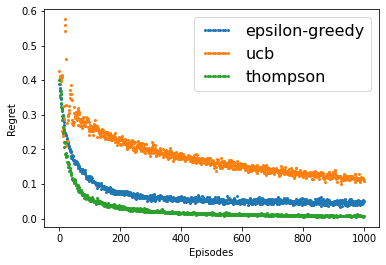

In [12]:
# Experiment 
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)


**Experiment 2**

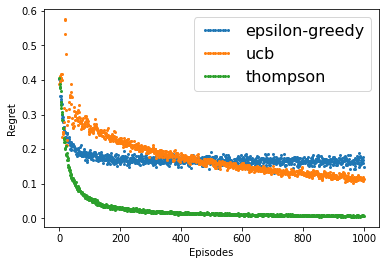

In [13]:
# Experiment 
arm_count = 10 # number of arms in bandit
epsilon = 0.4
ucb_c = 2
stationary=True
experiment(arm_count)

**Experiment 3**

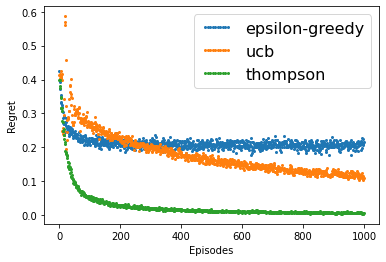

In [14]:
# Experiment 
arm_count = 10 # number of arms in bandit
epsilon = 0.5
ucb_c = 2
stationary=True
experiment(arm_count)

**Experiment 4**

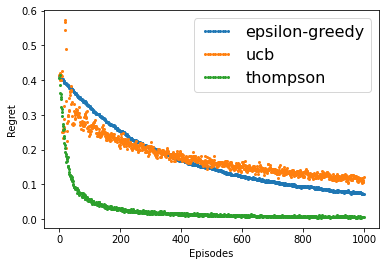

In [15]:
# Experiment 
arm_count = 10 # number of arms in bandit
epsilon = 0.01
ucb_c = 2
stationary=True
experiment(arm_count)

**Observation**

From the above expermiments, it can be observed that Epsilon-Greedy fails for large values and small values of Epsilon E. 

For the least regret for the least number of episodes taken, Epsilon E=0.1 is the best value.

# **Upper Confidence Bound**

Hyper parameter for UCB is C which is the uncertainty measure

Experiment **1**

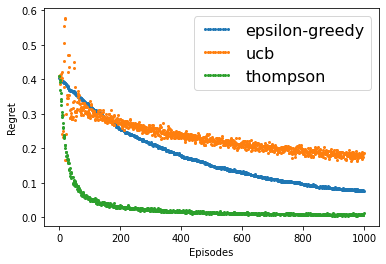

In [16]:
# Experiment 
arm_count = 10 # number of arms in bandit
epsilon = 0.01
ucb_c = 3
stationary=True
experiment(arm_count)

**Experiment 2**

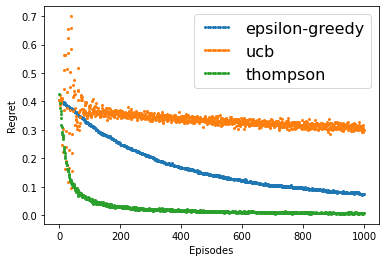

In [17]:
# Experiment 2
arm_count = 10 # number of arms in bandit
epsilon = 0.01
ucb_c = 8
stationary=True
experiment(arm_count)

**Experiment 3**

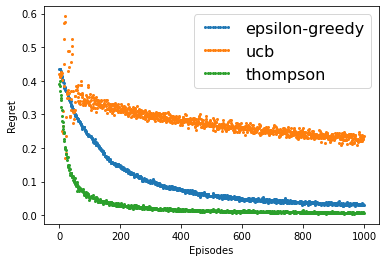

In [18]:
# Experiment 3
arm_count = 10 # number of arms in bandit
epsilon = 0.03
ucb_c = 4
stationary=True
experiment(arm_count)

**Experiment 4**

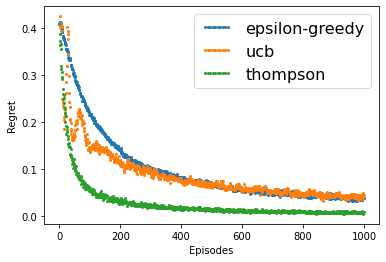

In [19]:
# Experiment 4
arm_count = 10 # number of arms in bandit
epsilon = 0.03
ucb_c = 1
stationary=True
experiment(arm_count)

**Experiment 5**

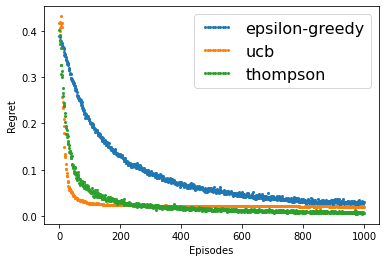

In [20]:
# Experiment 5
arm_count = 10 # number of arms in bandit
epsilon = 0.03
ucb_c = 0.1
stationary=True
experiment(arm_count)

**Observation**

For higher values of C, UCB performs poorly. As we reduce the values of C - when C = 01, we see that UCB performs well.

**How does the action space affect Thompson Sampling, E-Greedy, UCB and Random Sampling?**

The action space can be changed by the changing the number of Ads or bandits.

Here, we alter the action space and run experiments to see how each algorithm performs in different action space. 



**Experiment 1**

We plug in action space values initially with 20 ads

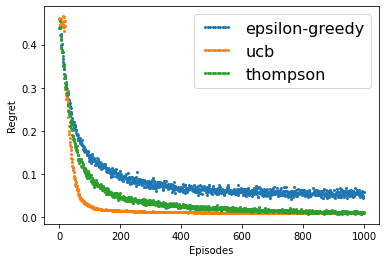

In [21]:
# Experiment 5
arm_count = 20 # number of arms in bandit
epsilon = 0.1
ucb_c = 0.1
stationary=True
experiment(arm_count)

Increasing the action space values to 70, timesteps to 3000 and simulations to 100 to observe if there is a change in the performance

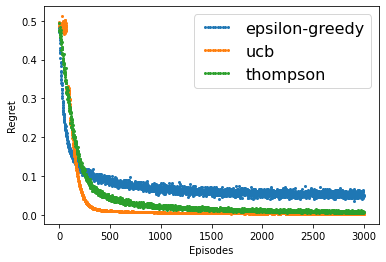

In [22]:
# Experiment 5
arm_count = 70 # number of arms in bandit
epsilon = 0.1
ucb_c = 0.1
stationary=True
experiment(arm_count, timesteps=3000, simulations=1000)

Increasing action space values to 200 with timesteps = 3000 and simulations = 1000

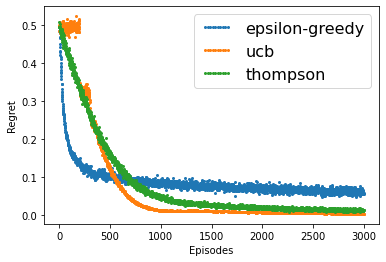

In [23]:
# Experiment 5
arm_count = 200 # number of arms in bandit
epsilon = 0.1
ucb_c = 0.1
stationary=True
experiment(arm_count, timesteps=3000, simulations=1000)

Plugging in lower arm_count value of 5 to see algorithm performance 

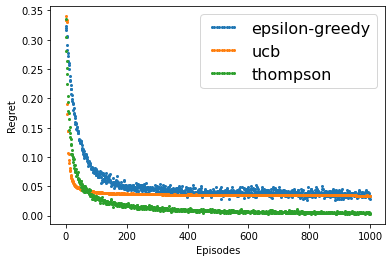

In [24]:
arm_count = 5 # number of arms in bandit
epsilon = 0.1
ucb_c = 0.1
stationary=True
experiment(arm_count)

**Observations**

The above experiments show that action space show that the performance of UCB in higher action space reduces.

Thompson Sampling is unaffected by the action space.

Epsilon - Greedy performs fairly similar and seems to be unaffected by the action space.

## **How does stationary affect Thompson Sampling, E-Greedy, UCB, and random sampling?**


Running the Experiment when Stationary = True

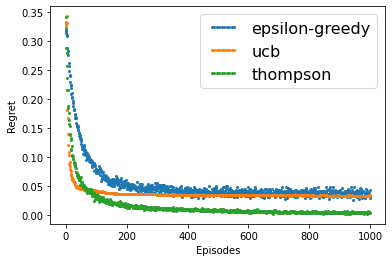

In [25]:
# Experiment 1
arm_count = 5 
epsilon = 0.1
ucb_c = 0.1
stationary=True
experiment(arm_count)

Running the Experiment when Stationary = False

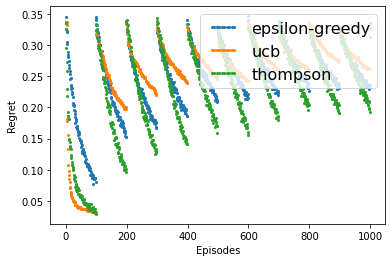

In [26]:
#Experiment 1
arm_count = 5 
epsilon = 0.1
ucb_c = 0.1    
stationary=False
experiment(arm_count)

As we see from the above two experiments, Non-Stationary affect doesn't let the algorithm reduce regret and behaves erratically.

## **When do Thompson Sampling, e-greedy, UBC, and random sampling stop exploring? Explain why. Explain the exploration-exploitation tradeoff** 

**Thompson Sampling**

An action is performed multiple times which is called exploration and based on the results obtained from the actions, either rewards or penalties, further actions are performed with the goal to maximize the reward which is called exploitation. In other words, new choices are explored to maximize rewards while exploiting the already explored choices.

It continues to explore actions that are less likely to get a good reward as well.

Exploration reduces after many episodes and exploitation increases.

**Epsilon-Greedy** 

 Epsilon Greedy's exploration rate depends on the value of epsilon. Epsilon-Greedy stops exploring when Epsilon is Zero

**UCB**

UCB continues explore until the confidence interval goes up a point value

**Random Sampling**

 Random Sampling will continue to explore infinitely if there is no stopping condition.

## **Exploration - Exploitation Tradeoff**

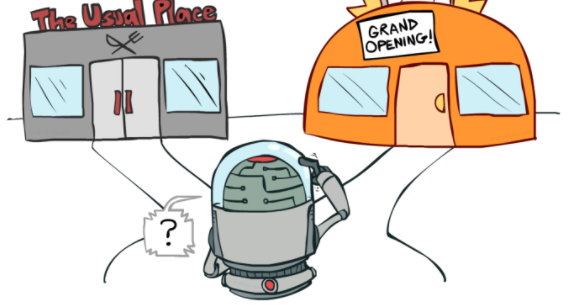

The exploration-exploitation trade-off is a dilemma in Reinforcement learning where an agent has to choose between exploring the environment and exploiting the environment.

An agent initially explores to learn about the environment to learn about the environment and sepcific actions. Based on the rewards obtained from actions, it exploits those actions to maximize the gain of rewards.

Exploration rate like Epsilon can be used to control the exploration rate and exploitation rate.

**Exploration vs Exploitation**

Exploration allows an agent to improve its current knowledge about each action, hopefully leading to long-term benefit. Improving the accuracy of the estimated action-values, enables an agent to make more informed decisions in the future.

Exploitation on the other hand, chooses the greedy action to get the most reward by exploiting the agent’s current action-value estimates. But by being greedy with respect to action-value estimates, may not actually get the most reward and lead to sub-optimal behaviour.
When an agent explores, it gets more accurate estimates of action-values. And when it exploits, it might get more reward. It cannot, however, choose to do both simultaneously, which is also called the exploration-exploitation dilemma.

**Epsilon-Greedy Action Selection** 

Epsilon-Greedy is a simple method to balance exploration and exploitation by choosing between exploration and exploitation randomly.
The epsilon-greedy, where epsilon refers to the probability of choosing to explore, exploits most of the time with a small chance of exploring.




## **Thompson Sampling with Normal Distribution (Non-Beta Distribution)**

Q) Modify the Thompson Sampling to run with a different distribution (e.g. Parteo, Normal, etc)

We take an example of the slot machine and apply a Normal Distribution.


In [27]:
import numpy as np

#Define the total number of turns (i.e., the number of times we will play a slot machine).
#Remember, we have $1,000 available, and each turn costs $1. We thus have 1,000 turns.
number_of_turns = 1000

#define the total number of slot machines
number_of_slot_machines = 6

#Define arrays where we can keep track of our wins (positive rewards) 
#and losses (negative rewards) for each slot machine.
#number_of_positive_rewards = np.zeros(number_of_slot_machines)
#number_of_negative_rewards = np.zeros(number_of_slot_machines)

#define a seed for the random number generator (to ensure that results are reproducible)
np.random.seed(5)

#create a random conversion rate between 1% and 15% for each slot machine
conversion_rates = np.random.uniform(0.01, 0.15, number_of_slot_machines)

#Show conversion rates for each slot machine. Remember that in a real-world scenario
#the decision-maker would not know this information!
for i in range(6):
  print('Conversion rate for slot machine {0}: {1:.2%}'.format(i, conversion_rates[i]))

Conversion rate for slot machine 0: 4.11%
Conversion rate for slot machine 1: 13.19%
Conversion rate for slot machine 2: 3.89%
Conversion rate for slot machine 3: 13.86%
Conversion rate for slot machine 4: 7.84%
Conversion rate for slot machine 5: 9.56%


In [28]:
#The data set is a matrix with one row for each turn, and one column for each slot machine.
#Each item in the matrix represents the outcome of what would happen if we were to play a  
#particular slot machine on that particular turn. A value of "1" indicates that we would win, 
#while a value of "0" indicates that we would lose. The number of "wins" for each slot machine
#is determined by its conversion rate.
outcomes = np.zeros((number_of_turns, number_of_slot_machines)) #create a two-dimensional numpy array, and fill it with zeros
for turn_index in range(number_of_turns): #for each turn
    for slot_machine_index in range(number_of_slot_machines): #for each slot machine
        #Get a random number between 0.0 and 1.0.
        #If the random number is less than or equal to this slot machine's conversion rate, then set the outcome to "1".
        #Otherwise, the outcome will be "0" because the entire matrix was initially filled with zeros.
        if np.random.rand() <= conversion_rates[slot_machine_index]:
            outcomes[turn_index][slot_machine_index] = 1

#display the first 15 rows of data
print(outcomes[0:15, 0:6]) #this sort of indexing means "rows 0 to 14" (i.e., the first 15 rows) and "columns 0 through 5" (i.e., the first six columns)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]]


In [29]:
#show means (i.e., conversion rates) for each column (i.e., for each slot machine)
for i in range(6):
  print('Mean for column {0}: {1:.2%}'.format(i, np.mean(outcomes[:, i])))

#show true conversion rate
for i in range(6):
  print('True conversion rate for column {0}: {1:.2%}'.format(i, conversion_rates[i]))

Mean for column 0: 4.90%
Mean for column 1: 10.70%
Mean for column 2: 3.20%
Mean for column 3: 13.60%
Mean for column 4: 7.60%
Mean for column 5: 8.70%
True conversion rate for column 0: 4.11%
True conversion rate for column 1: 13.19%
True conversion rate for column 2: 3.89%
True conversion rate for column 3: 13.86%
True conversion rate for column 4: 7.84%
True conversion rate for column 5: 9.56%


## **Normal Distribution**

In [30]:
#for each turn
rewards = [[0] for i in range(number_of_slot_machines)]
for turn_index in range(number_of_turns):
    index_of_machine_to_play = -1
    max_beta = -1 # note that max beta

    #determine which slot machine to play for this turn
    for slot_machine_index in range(number_of_slot_machines): #for each slot machine
        #Define the shape parameters for the beta distribution. The shape will depend on the number
        #of wins and losses that have thus far been observed for this particular slot machine.
        #a = number_of_positive_rewards[slot_machine_index] + 1
        #b = number_of_negative_rewards[slot_machine_index] + 1
        mean = np.mean(rewards[slot_machine_index])

        std = np.std(rewards[slot_machine_index])
        #Get a random value from the beta distribution whose shape is defined by the number of
        #wins and losses that have thus far been observed for this slot machine
        random_beta = np.random.normal(mean, std)
        #print(random_beta)

        #if this is the largest beta value thus far observed for this iteration
        if random_beta > max_beta:
            max_beta = random_beta #update the maximum beta value thus far observed
            index_of_machine_to_play = slot_machine_index #set the machine to play to the current machine
    
    #play the selected slot machine, and record whether we win or lose
    if outcomes[turn_index][index_of_machine_to_play] == 1:
        rewards[index_of_machine_to_play].append(1)
    else:
        rewards[index_of_machine_to_play].append(0)

print('Number of turns {0}:'.format(number_of_turns))  

#compute and display the total number of times each slot machine was played

number_of_times_played = [0 for i in range(number_of_slot_machines)]
for n in range (number_of_slot_machines):
  number_of_times_played[n] =len(rewards[n])

#number_of_times_played = number_of_positive_rewards + number_of_negative_rewards 
for slot_machine_index in range(number_of_slot_machines): #for each slot machine
    print('Slot machine {0} was played {1} times that is, {2:.2%}'.format(slot_machine_index, number_of_times_played[slot_machine_index], (number_of_times_played[slot_machine_index]/number_of_turns)))

#identify and display the best slot machine to play
print('\nOverall Conclusion: The best slot machine to play is machine {}!'.format(np.argmax(number_of_times_played)))

#show true conversion rate
for i in range(6):
  print('True conversion rate for column {0}: {1:.2%}'.format(i, conversion_rates[i]))

Number of turns 1000:
Slot machine 0 was played 262 times that is, 26.20%
Slot machine 1 was played 319 times that is, 31.90%
Slot machine 2 was played 130 times that is, 13.00%
Slot machine 3 was played 277 times that is, 27.70%
Slot machine 4 was played 17 times that is, 1.70%
Slot machine 5 was played 1 times that is, 0.10%

Overall Conclusion: The best slot machine to play is machine 1!
True conversion rate for column 0: 4.11%
True conversion rate for column 1: 13.19%
True conversion rate for column 2: 3.89%
True conversion rate for column 3: 13.86%
True conversion rate for column 4: 7.84%
True conversion rate for column 5: 9.56%


**How long does Thompson Sampling, E-Greedy, UCS and random sampling remember the past actions?**

**Thompson Sampling**

Thompson Sampling remembers the past actions through its distribution which are then exploited/

**E-Greedy**

Epsilon-Greedy remembers its past actions in the form of (action,reward). This sequence of action and reward is then exploited.

**UCB**

Past actions are remembered through unexplored or less explored actions which have a big confidence interval

**Random Sampling**

Random Sampling does not remember its actions and explores and exploits at random

## **Conclusion**

We explored different sampling techniques and algorithms, learned the importance of hyperparameters and how it affects the algorithm's performance. 

Observed how stationary and non stationary affect the algorithm's performance

Observed how Thompson Sampling performs across different Non-Beta distributions like Normal Distributions.

### **REFERENCES**

1. Nicholas Brown - Reinforcement Learning - Thompson Sampling & the Multi-Armed Bandit Problem - [Link](https://colab.research.google.com/drive/1gdR7k7jtSRqYnPNHcbAKdIjGRjQXpfnA)
2. Dr. Daniel Soper - Reinforcement Learning: Thompson Sampling & The Multi Armed Bandit Problem - [link](https://www.youtube.com/watch?v=yQwJiFFIgjA&ab_channel=Dr.DanielSoper)
3. Github Repo - Andre Cianflone - Thompson sampling -  [link](https://northeastern.instructure.com/courses/84983/pages/thompson-sampling-and-the-multi-armed-bandit-problem?module_item_id=6076486)
4. Github Repo - Dan Russo, Benjamin Van Roy - A Tutorial on Thompson Sampling [link](https://github.com/iosband/ts_tutorial)
5. Github Repo - Multi Armed Bandit - Thompson Sampling [link](https://github.com/abhi-gm/Reinforcement-Learning-Ad-Campaing-Optimization/blob/master/AD_Campaing_modeling_with_Reinforcemnet_Learning.ipynb)
5. Epsilon-Greedy Algorithm in Reinforcement Learning - [link](https://www.geeksforgeeks.org/epsilon-greedy-algorithm-in-reinforcement-learning/)
6. Upper Confidence Bound - [link](https://www.geeksforgeeks.org/upper-confidence-bound-algorithm-in-reinforcement-learning/)
6. Action - Space [link](https://arxiv.org/abs/2004.00980) 
7. Exploration - Exploitation - [link](https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf)

Referred the above links for concepts, explanation and code. Made changes to the code wherever necessary. 


### **LICENSE**

Copyright <2021> Keshav K L

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.